In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [ ]:
%cd '/content/gdrive/MyDrive/microsoft_ia/sign'

In [23]:
import cv2
import os
import time

In [5]:
import tensorflow as tf

In [25]:
background = None
accumulated_weight = 0.5

#Création des dimensions du ROI

ROI_top = 50
ROI_bottom = 250
ROI_right = 50
ROI_left = 250

#Project: gesture-recognition, License: MIT License, OpenSource

def cal_accum_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [27]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)
    _ , thresholded = cv2.threshold(diff, threshold,255,cv2.THRESH_BINARY)
    
    # Saisi les contours
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        return None
    else:
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        return (thresholded, hand_segment_max_cont)

In [40]:
cam = cv2.VideoCapture(0)

num_frames = 0
element = 'A'

num_imgs_taken = 0

while True:
    ret, frame = cam.read()
    
    # Eviter l'inversement de l'image
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    
    if num_frames < 60:
        cal_accum_avg(gray_frame, accumulated_weight)
        
        # Détection du Background
        if num_frames <= 299:
            cv2.putText(frame_copy, "Chargement..", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
            
    # Configuration
    elif num_frames <= 300: 
        hand = segment_hand(gray_frame)
        cv2.putText(frame_copy, "Configuration.." + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255),2)
        
        # Voir si la main est bien détectée
        if hand is not None:
            
            thresholded, hand_segment = hand
            
            # Dessiner les contours de la main
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right,ROI_top)], -1, (255, 0, 0),1)
            
            cv2.putText(frame_copy, str(num_frames)+" Pour "+ str(element),(70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Affiche l'image prise
            cv2.imshow("Image traitée", thresholded)
    
    else: 
        # Segmentation de la main
        hand = segment_hand(gray_frame)
        
        # Repérer si la main est là
        if hand is not None:
            
            # unpack the thresholded img and the max_contour...
            thresholded, hand_segment = hand
            
            # Dessiner le contour de la main
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1) 
            cv2.putText(frame_copy, str(num_frames), (70, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            cv2.putText(frame_copy, str(num_imgs_taken) + 'Enregistrement pour ' + str(element), (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
            # Afficher l'image de la main traitée
            cv2.imshow("Image traitée", thresholded)
            if num_imgs_taken <= 299:
                cv2.imwrite(r"C:\\Users\\utilisateur\\Documents\\data_sign\\"+str(element)+"\\"+str(num_imgs_taken+1) +'.jpg', thresholded)
                
            else:
                break
            num_imgs_taken +=1
            
        else:
            cv2.putText(frame_copy, 'Pas de main détectée !', (200, 400), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Drawing ROI on frame copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right,ROI_bottom), (255,128,0), 3)
    
    # increment the number of frames for tracking
    num_frames += 1
    # Display the frame with segmented hand
    cv2.imshow("Sign Detection", frame_copy)
    # Closing windows with Esc key...(any other key with ord can be used too.)
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
        
        
#Releasing the camera & destroying all the windows...
cv2.destroyAllWindows()
cam.release()

In [3]:
data_direction = "./data_sign"
categories = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z','_SPACE']

for category in categories:
    path = os.path.join(data_direction, category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path, img))

In [4]:
len(categories)

27

In [5]:
print(img_array.shape)

(200, 200, 3)


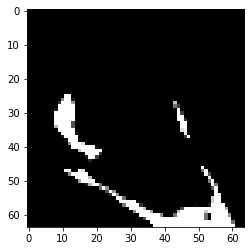

In [6]:
import matplotlib.pyplot as plt

IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
new_array = cv2.cvtColor(new_array, cv2.COLOR_BGR2RGB)
plt.imshow(new_array, cmap ='gray')
plt.show()

In [7]:
data_list = []

def create_data_list():
    for category in categories:
        path = os.path.join(data_direction, category)
        class_num = categories.index(category)
        for img in os.listdir(path):
            img_array = cv2.imread(os.path.join(path, img))
            new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data_list.append([new_array, class_num])
       
    
create_data_list()

In [8]:
len(data_list)

8100

In [9]:
import random

random.shuffle(data_list)

In [10]:
images = []
labels = []

In [11]:
import numpy as np

for feature, label in data_list:
    images.append(feature)
    labels.append(label)
    
images = np.array(images).reshape(-1, IMG_SIZE, IMG_SIZE, 3)

In [12]:
labels = np.array(labels)

In [13]:
from sklearn.model_selection import train_test_split

x_app, x_val, y_app, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True)

In [16]:
x_app = x_app.astype('float')/255
x_val = x_val.astype('float')/255

y_app = np.array(y_app)
y_val = np.array(y_val)

In [14]:
print("x_app.shape :\t ", x_app.shape)
print("x_val.shape :\t ", x_val.shape)
print("y_app.shape :\t ", y_app.shape)
print("y_val.shape :\t ", y_val.shape)

x_app.shape :	  (6480, 64, 64, 3)
x_val.shape :	  (1620, 64, 64, 3)
y_app.shape :	  (6480,)
y_val.shape :	  (1620,)


In [15]:
y_app = tf.keras.utils.to_categorical(y_app, 27)
y_val = tf.keras.utils.to_categorical(y_val, 27)

print("y_app.shape :\t ",y_app.shape)
print("y_val.shape :\t ",y_val.shape)

y_app.shape :	  (6480, 27)
y_val.shape :	  (1620, 27)


In [20]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout

model = tf.keras.Sequential()

model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)))
model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))

model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(Dropout(0.5))

model.add(tf.keras.layers.Flatten())
model.add(Dropout(0.5))

model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(27, activation='softmax'))

model.compile(optimizer ='adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'])

In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

augmentation = ImageDataGenerator(samplewise_center=True, 
                                  samplewise_std_normalization=True, 
                                  validation_split=0.2)

In [8]:
import numpy as np
import cv2
import tensorflow as tf

In [9]:
model = tf.keras.models.load_model(r"model_sign")
background = None
accumulated_weight = 0.5
ROI_top = 50
ROI_bottom = 250
ROI_right = 50
ROI_left = 250

In [10]:
word_dict = {0:'A',1:'B',2:'C',3:'D',4:'E',5:'F',6:'G',7:'H',8:'I',9:'J',10:'K',11:'L',12:'M',13:'N',14:'O',15:'P',16:'Q',17:'R',18:'S',19:'T',20:'U',21:'V',22:'W',23:'X',24:'Y',25:'Z',26:'_SPACE'}


In [11]:
def cal_accum_avg(frame, accumulated_weight):
    global background
    
    if background is None:
        background = frame.copy().astype("float")
        return None
    cv2.accumulateWeighted(frame, background, accumulated_weight)

In [12]:
def segment_hand(frame, threshold=25):
    global background
    
    diff = cv2.absdiff(background.astype("uint8"), frame)
    _ , thresholded = cv2.threshold(diff, threshold, 255,cv2.THRESH_BINARY)
    
     #Fetching contours in the frame (These contours can be of hand or any other object in foreground) …
    contours, hierarchy = cv2.findContours(thresholded.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # If length of contours list = 0, means we didn't get any contours...
    
    if len(contours) == 0:
        return None
    else:
        # The largest external contour should be the hand 
        hand_segment_max_cont = max(contours, key=cv2.contourArea)
        
        # Returning the hand segment(max contour) and the thresholded image of hand...
        return (thresholded, hand_segment_max_cont)

In [18]:
cam = cv2.VideoCapture(0)
num_frames =0
while True:
    ret, frame = cam.read()
    # flipping the frame to prevent inverted image of captured frame...
    
    frame = cv2.flip(frame, 1)
    frame_copy = frame.copy()
    # ROI from the frame
    roi = frame[ROI_top:ROI_bottom, ROI_right:ROI_left]
    gray_frame = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
    gray_frame = cv2.GaussianBlur(gray_frame, (9, 9), 0)
    if num_frames < 70:
        
        cal_accum_avg(gray_frame, accumulated_weight)
        
        cv2.putText(frame_copy, "Chargement", (80, 400), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,0,255), 2)
    
    else: 
        # segmenting the hand region
        hand = segment_hand(gray_frame)
        
        # Checking if we are able to detect the hand...
        if hand is not None:
            
            thresholded, hand_segment = hand
            # Drawing contours around hand segment
            cv2.drawContours(frame_copy, [hand_segment + (ROI_right, ROI_top)], -1, (255, 0, 0),1)
            
            cv2.imshow("Image traitée", thresholded)
            
            thresholded = cv2.resize(thresholded, (64, 64))
            thresholded = cv2.cvtColor(thresholded, cv2.COLOR_GRAY2RGB)
            thresholded = np.reshape(thresholded, (1,thresholded.shape[0],thresholded.shape[1],3))
            
            pred = model.predict(thresholded)
            cv2.putText(frame_copy, word_dict[np.argmax(pred)], (170, 45), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,255), 2)
            
    # Draw ROI on frame_copy
    cv2.rectangle(frame_copy, (ROI_left, ROI_top), (ROI_right, ROI_bottom), (255,128,0), 3)
    # incrementing the number of frames for tracking
    num_frames += 1
    # Display the frame with segmented hand
    cv2.putText(frame_copy, "Prédiction", (10, 20), cv2.FONT_ITALIC, 0.5, (51,255,51), 1)
    cv2.imshow("Sign Detection", frame_copy)
    # Close windows with Esc
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
# Release the camera and destroy all the windows
cam.release()
cv2.destroyAllWindows()